<a href="https://colab.research.google.com/github/UMassIonTrappers/Introduction-to-Quantum-Computing/blob/main/labs/Lab_08_QPU_Benchmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 550/650

## Introduction to Quantum Computing

Robert Niffenegger (rniffenegger@umass.edu )

In [3]:

try:
  import qiskit
  print('Qiskit imported')
except ImportError:
  print('Install Qiskit')
  !pip install --quiet qiskit
  !pip install --quiet qiskit[visualization]
  # !pip install --quiet git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

try:
  from qiskit_aer import QasmSimulator
  print('Qiskit Aer imported');
except ImportError:
  print('Install Qiskit-Aer')
  !pip install --quiet qiskit-aer

try:
  from qiskit_ibm_runtime import QiskitRuntimeService
  print('Qiskit-IBM-Runtime imported')

except ImportError:
  print('Install Qiskit-IBM-Runtime')
  !pip install --quiet qiskit-ibm-runtime
  !pip install --quiet qiskit_ibm_provider[visualization]

# !pip install --quiet graphviz
# !apt-get install graphviz

Qiskit imported
Qiskit Aer imported
Qiskit-IBM-Runtime imported


### Initialize

In [8]:
%matplotlib inline
from IPython.display import display, Math, Image
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt, sin, cos
from scipy import constants
from scipy.optimize import curve_fit

import math
import time


#Plot setup
from pylab import *
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML


#Qisket imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city, array_to_latex
from qiskit_aer import QasmSimulator
from qiskit.quantum_info import Statevector

from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

#Qisket imports
# from qiskit.providers.aer import QasmSimulator
# from qiskit.providers.ibmq import least_busy
# from qiskit.providers.basicaer import BasicAer
# from qiskit.providers.aer.noise import *

from qiskit.circuit.library import *
from qiskit.quantum_info.operators import Operator

# """Show ALL outputs, not just last expression"""
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# Lab 8 - Benchmarking QPUs

Topics covered:
* T1 - qubit lifetime
* T2 - qubit coherence time
* GHZ states - multi-particle entangled states
* GHZ parity contrast decay vs. number of qubits



# Benchmarking QPUs



https://learning.quantum.ibm.com/tutorial/real-time-benchmarking-for-qubit-selection

In [5]:
token = "INSERT YOUR TOKEN HERE"

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum", # `channel` distinguishes between different account types
  overwrite=True,
  set_as_default=True
)

In [7]:
from qiskit_ibm_runtime.fake_provider import FakeBrisbane

service = QiskitRuntimeService()

backend = FakeBrisbane()
backend.refresh(service)

## T2 - Phase Coherence time

Let's measure the T2 time (with echo) of the qubits on ibm_brisbane

In [9]:
# Parallel Hahn echo function
def parallel_hahn_echo(delay, backend, num_qubits):
    qc = QuantumCircuit(num_qubits, num_qubits)
    for q in range(num_qubits):
        # qc.x(q)
        qc.h(q)
        qc.delay(delay / 2, q, unit="s")
        qc.x(q)
        qc.delay(delay / 2, q, unit="s")
        qc.h(q)
        qc.measure(q, q)
    return qc

# Exponential decay function
def exp_decay(t, A, T2, B):
    return A * np.exp(-t / T2) + B

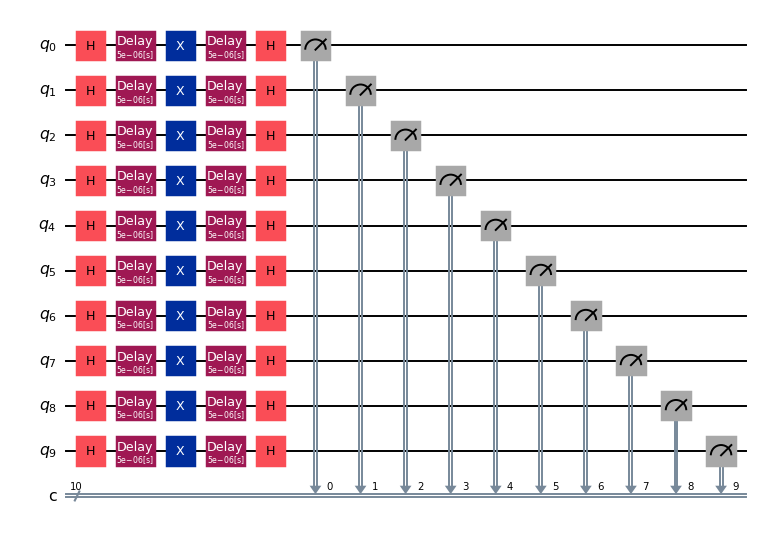

In [10]:
circuit = parallel_hahn_echo( 10e-6, backend, num_qubits=10)
circuit.draw('mpl',scale=0.7)

In [ ]:
backend = FakeBrisbane()
num_qubits = 10

# Define delays in microseconds (converted to seconds)
delays_us = [1, 50.0, 100.0, 200.0, 300.0 ,400.0, 500.0]
delay_times = [d * 1.0e-6 for d in delays_us]

# Store probabilities per qubit
probs_per_qubit = {q: [] for q in range(num_qubits)}

# Run simulations
for delay in delay_times:
    print(delay)
    circuit = parallel_hahn_echo(delay, backend, num_qubits)
    transpiled = transpile(circuit, backend)
    job = backend.run(transpiled, shots=100)
    result = job.result()
    counts = result.get_counts()

    for qubit in range(num_qubits):
        one_count = 0
        for bitstring, count in counts.items():
            if bitstring[::-1][qubit] == '1':
                one_count += count
        prob = 1-one_count / 100
        probs_per_qubit[qubit].append(prob)


1e-06
4.9999999999999996e-05
9.999999999999999e-05
0.00019999999999999998
0.0003
0.00039999999999999996
0.0005


In [12]:
# Fit T2 per qubit
t2_estimates = {}
for q in range(num_qubits):
    try:
        popt, _ = curve_fit(exp_decay, delays_us, probs_per_qubit[q], p0=[0.5, 50, 0.5])
        t2_estimates[q] = popt[1]  # T2
    except RuntimeError:
        t2_estimates[q] = None

# Print results
print("\nEstimated T₂ values (in µs):")
for q in range(num_qubits):
    t2 = t2_estimates[q]
    if t2:
        print(f"Qubit {q}: T₂ ≈ {t2:.2f} µs")
    else:
        print(f"Qubit {q}: Fit failed")



Estimated T₂ values (in µs):
Qubit 0: T₂ ≈ 253.50 µs
Qubit 1: T₂ ≈ 156.62 µs
Qubit 2: T₂ ≈ 54.66 µs
Qubit 3: T₂ ≈ 282.42 µs
Qubit 4: T₂ ≈ 179.88 µs
Qubit 5: T₂ ≈ 147.84 µs
Qubit 6: T₂ ≈ 350.27 µs
Qubit 7: T₂ ≈ 646.61 µs
Qubit 8: T₂ ≈ 197.67 µs
Qubit 9: T₂ ≈ 130.84 µs


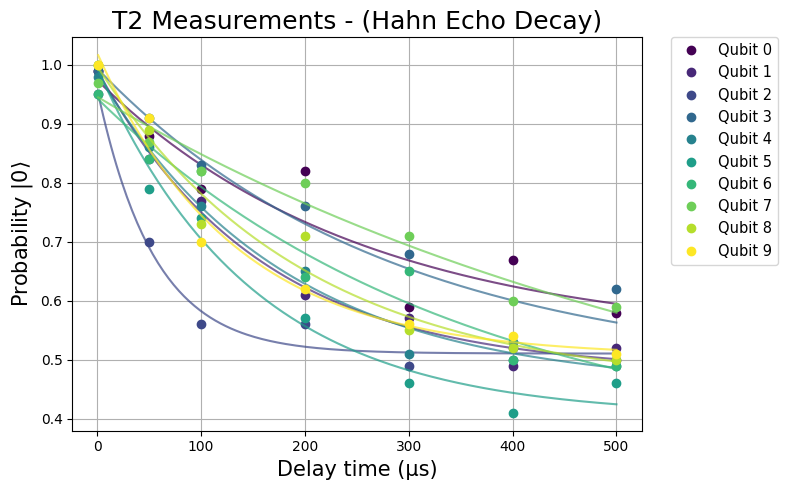

In [13]:
# Plot all qubit decays
plt.figure(figsize=(8, 5))
fs =15

colors = plt.cm.viridis(np.linspace(0, 1, num_qubits))

for q in range(num_qubits):
    plt.plot(delays_us, probs_per_qubit[q], 'o', label=f"Qubit {q}", color=colors[q])

    # If fit succeeded, plot fit curve
    if t2_estimates[q]:
        A, T2, B = curve_fit(exp_decay, delays_us, probs_per_qubit[q], p0=[0.5, 50, 0.5])[0]
        t_fit = np.linspace(min(delays_us), max(delays_us), 200)
        plt.plot(t_fit, exp_decay(t_fit, A, T2, B), '-', color=colors[q], alpha=0.7)


plt.xlabel("Delay time (µs)",fontsize = fs)
plt.ylabel(r'Probability $|0\rangle$',fontsize = fs)
plt.title("T2 Measurements - (Hahn Echo Decay)",fontsize = fs*1.2)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0 , fontsize = fs*0.7)
plt.tight_layout()
plt.show()


## Plot Map of QPU with errors etc.

In [14]:
from qiskit.visualization import plot_error_map, plot_coupling_map
from qiskit.transpiler import CouplingMap
from graphviz import Graph 


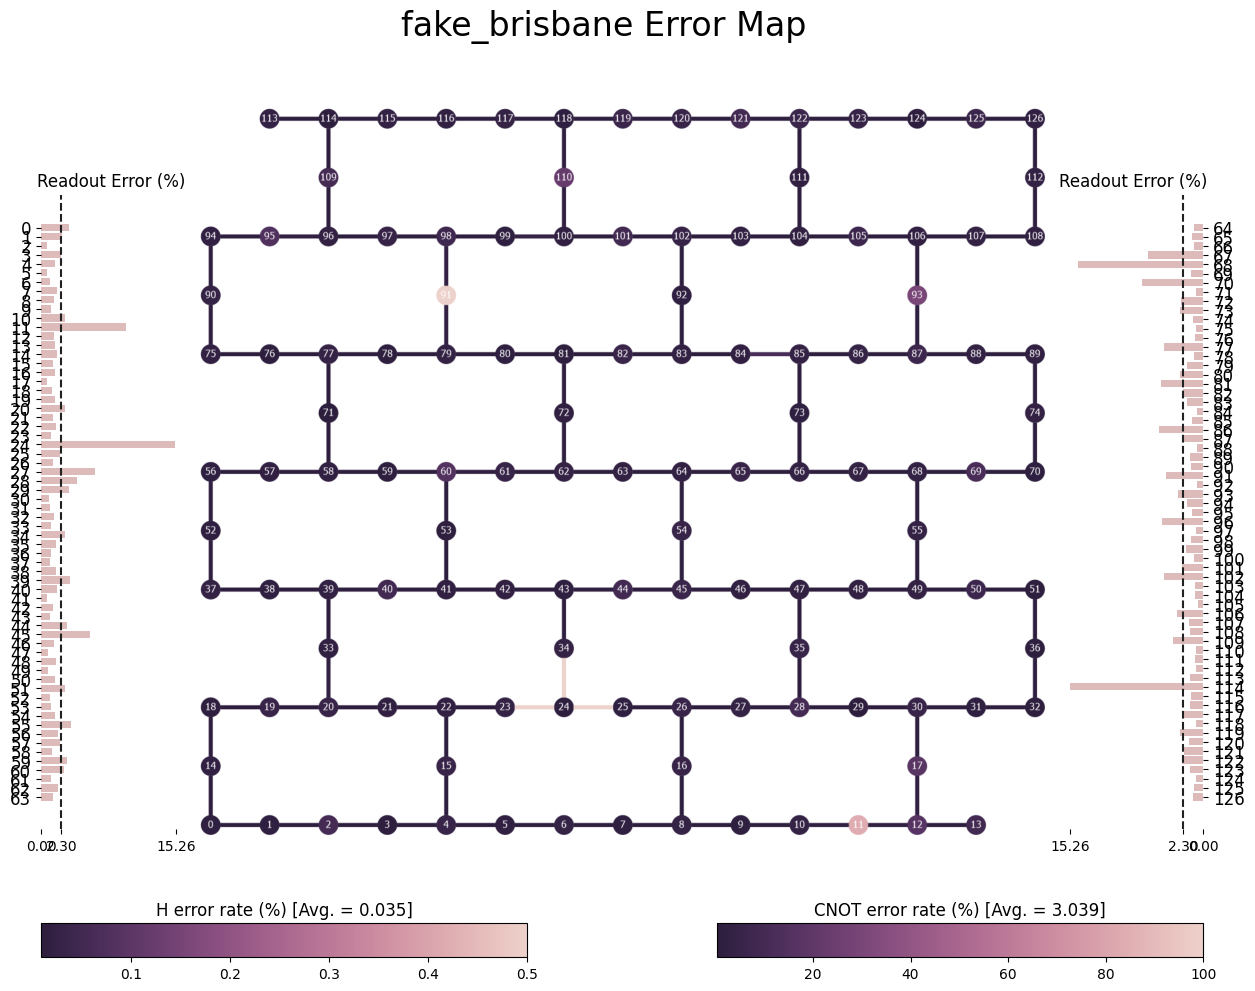

In [15]:
plot_error_map(backend)
# plot_error_map(backend, figsize=(30, 24))

## T1 - Excited State lifetime

Next we can measure T1 (the lifetime of the qubits)

In [15]:
# T1 decay function
def exp_decay(t, A, T1, B):
    return A * np.exp(-t / T1) + B

# Parallel T1 circuit generator
def parallel_t1(delay, backend, num_qubits):
    qc = QuantumCircuit(num_qubits, num_qubits)
    for q in range(num_qubits):
        qc.x(q)  # excite
        qc.delay(delay, q, unit="s")  # wait
        qc.measure(q, q)
    return qc

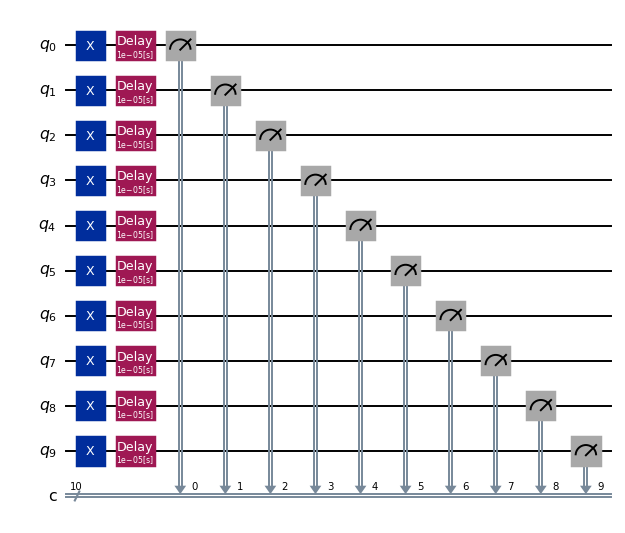

In [16]:
circuit = parallel_t1( 10e-6, backend, num_qubits=10)
circuit.draw('mpl',scale=0.7)

In [54]:
# Setup
backend = FakeBrisbane()
num_qubits = 10  # or more
delays_us = [1, 50, 100, 200, 300, 400 ,500 ]  # microseconds
delay_times = [d * 1e-6 for d in delays_us]  # convert to seconds

shots = 1000
# Run circuits and collect data
probs_per_qubit = {q: [] for q in range(num_qubits)}

for delay in delay_times:
    print(delay)
    circuit = parallel_t1(delay, backend, num_qubits)
    transpiled = transpile(circuit, backend)
    job = backend.run(transpiled, shots=shots)
    result = job.result()
    counts = result.get_counts()

    for qubit in range(num_qubits):
        one_count = 0
        for bitstring, count in counts.items():
            if bitstring[::-1][qubit] == '1':
                one_count += count
        probs_per_qubit[qubit].append(one_count / shots)


1e-06
4.9999999999999996e-05
9.999999999999999e-05
0.00019999999999999998
0.0003
0.00039999999999999996
0.0005


In [21]:
# Fit T1 for each qubit
t1_estimates = {}
for q in range(num_qubits):
    try:
        popt, _ = curve_fit(exp_decay, delays_us, probs_per_qubit[q], p0=[0.9, 50, 0.1])
        t1_estimates[q] = popt[1]
    except RuntimeError:
        t1_estimates[q] = None

# Print results
print("\nEstimated T₁ values (in µs):")
for q in range(num_qubits):
    t1 = t1_estimates[q]
    if t1:
        print(f"Qubit {q}: T₁ ≈ {t1:.2f} µs")
    else:
        print(f"Qubit {q}: Fit failed")


Estimated T₁ values (in µs):
Qubit 0: T₁ ≈ 211.77 µs
Qubit 1: T₁ ≈ 294.68 µs
Qubit 2: T₁ ≈ 233.18 µs
Qubit 3: T₁ ≈ 209.12 µs
Qubit 4: T₁ ≈ 379.76 µs
Qubit 5: T₁ ≈ 178.26 µs
Qubit 6: T₁ ≈ 167.54 µs
Qubit 7: T₁ ≈ 267.29 µs
Qubit 8: T₁ ≈ 270.69 µs
Qubit 9: T₁ ≈ 169.04 µs


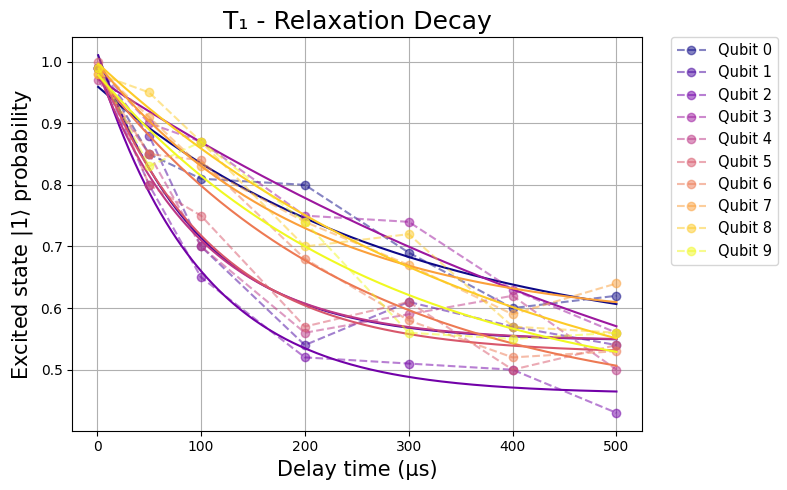

In [53]:
# Plot decay
plt.figure(figsize=(8, 5))
colors = plt.cm.plasma(np.linspace(0, 1, num_qubits))

for q in range(num_qubits):
    plt.plot(delays_us, probs_per_qubit[q], 'o--', label=f"Qubit {q}", color=colors[q],alpha=0.5)

    if t1_estimates[q]:
        A, T1, B = curve_fit(exp_decay, delays_us, probs_per_qubit[q], p0=[0.9, 50, 0.1])[0]
        t_fit = np.linspace(min(delays_us), max(delays_us), 200)
        plt.plot(t_fit, exp_decay(t_fit, A, T1, B), '-', color=colors[q], alpha=1.0)

plt.xlabel("Delay time (µs)",fontsize = fs)
plt.ylabel(r'Excited state $|1\rangle$ probability',fontsize = fs)
plt.title("T₁ - Relaxation Decay",fontsize = fs*1.2)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0 , fontsize = fs*0.7)
plt.tight_layout()
plt.show()


# Rabi Oscillations

In [66]:

# Create Rabi circuit with Ry pulse train
def rabi_circuit(reps, theta, qubit, num_qubits):
    qc = QuantumCircuit(num_qubits, num_qubits)
    for _ in range(reps):
        qc.ry(theta, qubit)
    qc.measure(qubit, qubit)
    return qc

# Setup
backend = FakeBrisbane()
num_qubits = 1
qubit = 0
theta = 0.15 * np.pi  # Small angle per step
steps = list(range(1, 30))  # Vary number of repetitions
theta_steps = [reps*theta for reps in steps]

# Run experiments
probs = []

for reps in steps:
    print(reps*theta)
    qc = rabi_circuit(reps, theta, qubit, num_qubits)
    transpiled = transpile(qc, backend)
    job = backend.run(transpiled, shots=1000)
    result = job.result()
    counts = result.get_counts()

    one_count = 0
    for bitstring, count in counts.items():
        if bitstring[::-1][qubit] == '1':
            one_count += count
    probs.append(one_count / 1000)


0.47123889803846897
0.9424777960769379
1.413716694115407
1.8849555921538759
2.356194490192345
2.827433388230814
3.2986722862692828
3.7699111843077517
4.241150082346221
4.71238898038469
5.183627878423159
5.654866776461628
6.126105674500097
6.5973445725385655
7.0685834705770345
7.5398223686155035
8.011061266653972
8.482300164692441
8.953539062730911
9.42477796076938
9.896016858807847
10.367255756846317
10.838494654884787
11.309733552923255
11.780972450961723
12.252211349000193
12.723450247038663
13.194689145077131
13.6659280431156


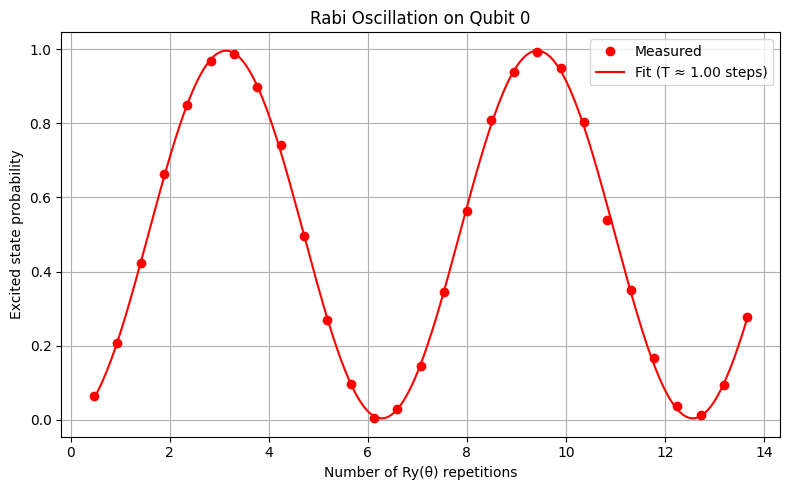

Rabi period Error (vs. calibration)=  0.017182282094863055 %


In [76]:
# Sinusoidal model for Rabi oscillation
def rabi_model(t, A, omega, phi, B):
    return A * np.cos(omega * t + phi) + B

# Fit to cosine model
try:
    popt, _ = curve_fit(rabi_model, theta_steps, probs, p0=[0.5, 1.0000, 0, 0.5])
    A, omega, phi, B = popt
    rabi_period = 1 / omega
except RuntimeError:
    rabi_period = None

# Plot
plt.figure(figsize=(8, 5))
plt.plot(theta_steps, probs, 'or', label='Measured')
if rabi_period:
    t_fit = np.linspace(min(theta_steps), max(theta_steps), 300)
    plt.plot(t_fit, rabi_model(t_fit, *popt), '-r',label=f"Fit (T ≈ {rabi_period:.2f} steps)")

plt.xlabel("Number of Ry(θ) repetitions")
plt.ylabel("Excited state probability")
plt.title(f"Rabi Oscillation on Qubit {qubit}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


print('Rabi period Error (vs. calibration)= ', abs(rabi_period-1)*100 ,'%')


# GHZ states - Greenberger–Horne–Zeilinger (GHZ) states

In [34]:

def create_ghz_circuit(num_qubits, phi):
    """
    Creates a GHZ state circuit with parity rotation around Z-axis
    for parity oscillation measurement.
    
    Args:
        num_qubits (int): Number of qubits for GHZ state.
        phi (float): Phase rotation angle to apply to each qubit.
        
    Returns:
        QuantumCircuit: GHZ state with Rz(phi) gates applied.
    """
    qc = QuantumCircuit(num_qubits, num_qubits)

    # GHZ state preparation
    qc.h(0)
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)
        
    qc.barrier()

    # Global rotation to induce parity oscillations
    for i in range(num_qubits):
        qc.u(pi/2 ,phi,-phi,i)



    qc.barrier()

    # Measurement
    qc.measure(range(num_qubits), range(num_qubits))

    return qc



## GHZ circuit with the final analysis pulse

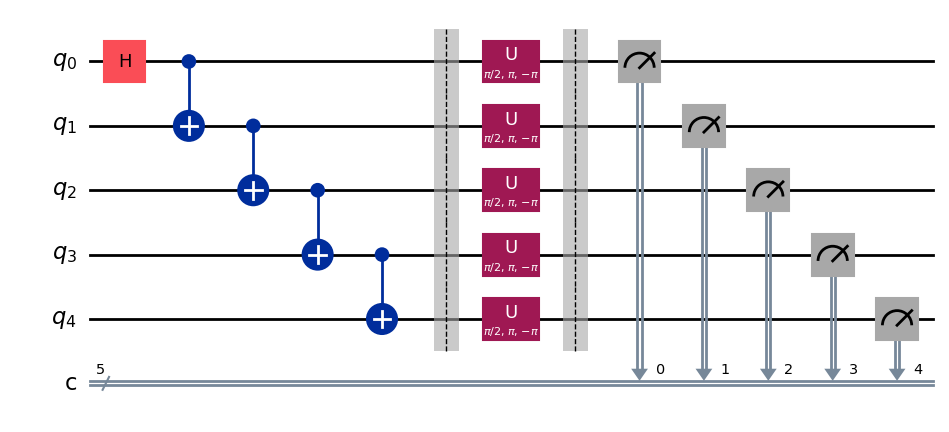

In [35]:

qc = create_ghz_circuit(5, pi)

qc.draw('mpl')

In [36]:
def parity_probabilities(counts):
    """     Return even and odd parity probabilities from measurement counts.     """
    even = 0
    odd = 0
    total = 0

    for bitstring, count in counts.items():
        total += count
        if bitstring.count('1') % 2 == 0:
            even += count
        else:
            odd += count

    p_even = even / total
    p_odd = odd / total
    return p_even, p_odd


In [37]:
def run_parity_oscillations(num_qubits=3, num_shots=1024, num_points=30):
    """
    Sweep over phi values and measure parity using FakeBrisbane.
    """
    backend = FakeBrisbane()
    phi_vals = np.linspace(0, 2 * np.pi, num_points)
    p_even_vals = []
    p_odd_vals = []

    for phi in phi_vals:
        qc = create_ghz_circuit(num_qubits, phi)
        tqc = transpile(qc, backend)
        job = backend.run(tqc, shots=num_shots)
        result = job.result()
        counts = result.get_counts()
        p_even, p_odd = parity_probabilities(counts)
        p_even_vals.append(p_even)
        p_odd_vals.append(p_odd)

    return phi_vals, p_even_vals, p_odd_vals

In [ ]:
phi_vals, p_even_vals, p_odd_vals = run_parity_oscillations(num_qubits=5, num_shots=1024, num_points=30)


In [41]:
def plot_parity_probabilities(phi_vals, p_even_vals, p_odd_vals, fs=14, title="GHZ Parity Oscillations"):
    """
    Plots the even and odd parity probabilities vs. rotation angle.

    Args:
        phi_vals (list or np.ndarray): Rotation angles (in radians).
        p_even_vals (list): Even parity probabilities.
        p_odd_vals (list): Odd parity probabilities.
        fs (int, optional): Font size for labels. Default is 14.
        title (str, optional): Plot title.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(phi_vals, p_even_vals, 'o-r', label='Even')
    plt.plot(phi_vals, p_odd_vals, 'o-b', label='Odd')
    plt.xlabel('Axis of analysis pulse [rad]', fontsize=fs)
    plt.ylabel('Probability', fontsize=fs)
    plt.title(title, fontsize=fs * 1.2)
    plt.ylim(0,1)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, fontsize=fs * 0.7)
    plt.tight_layout()
    plt.show()

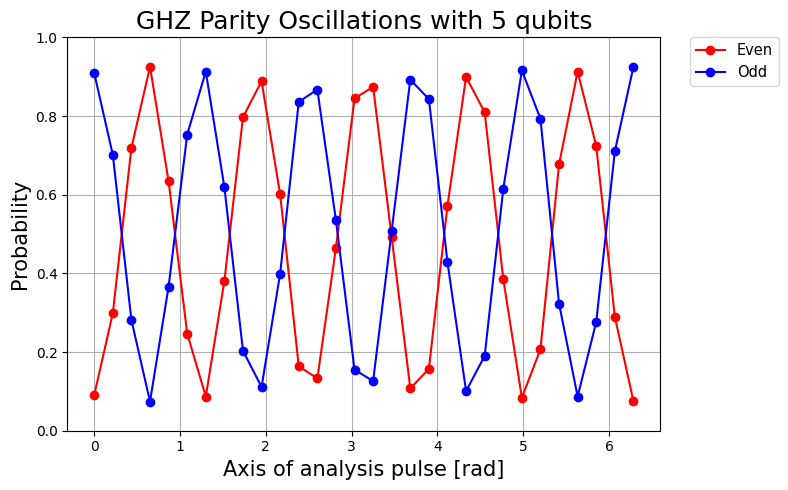

In [42]:
plot_parity_probabilities(phi_vals, p_even_vals, p_odd_vals, fs=15, title="GHZ Parity Oscillations with 5 qubits")

# Parity Contrast fit

To measure the fidelity we need to measure the contrast of the Parity oscillations

In [43]:
def _cosn_model(theta, A, theta0, B, n):
    """Cosine model with n oscillations."""
    return A * np.cos(n * theta + theta0) + B

def plot_parity_vs_theta_with_fit(theta_vals, p_even_vals, p_odd_vals, n_qubits, fs=14, title="GHZ Parity vs Axis Angle"):
    """
    Plots parity vs axis angle theta, fits even parity to extract contrast for n-qubit GHZ.

    Args:
        theta_vals (array): Rotation axis angles (radians).
        p_even_vals (array): Even parity probabilities.
        p_odd_vals (array): Odd parity probabilities.
        n_qubits (int): Number of qubits in the GHZ state.
        fs (int): Font size.
        title (str): Plot title.

    Returns:
        float: Extracted contrast.
    """
    theta_vals = np.array(theta_vals)
    p_even_vals = np.array(p_even_vals)

    # Fit to model: A * cos(n * θ + θ₀) + B
    def fit_func(theta, A, theta0, B):
        return _cosn_model(theta, A, theta0, B, n_qubits)

    p0 = [0.5, 0, 0.5]  # Initial guess: amplitude, phase offset, baseline
    popt, _ = curve_fit(fit_func, theta_vals, p_even_vals, p0=p0)
    A_fit, theta0_fit, B_fit = popt
    contrast = 2 * abs(A_fit)

    # Smooth curve for fit
    theta_smooth = np.linspace(min(theta_vals), max(theta_vals), 1000)
    fit_smooth = fit_func(theta_smooth, *popt)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(theta_smooth, fit_smooth, '-r', label=f'Fit: Contrast = {contrast:.2f}')
    plt.plot(theta_smooth, 1-fit_smooth, '-b', label=f'Fit: Contrast = {contrast:.2f}')
    plt.plot(theta_vals, p_even_vals, 'or', label='Even (data)')
    plt.plot(theta_vals, p_odd_vals, 'ob', label='Odd (data)')
    plt.xlabel('Axis angle θ (rad)', fontsize=fs)
    plt.ylabel('Probability', fontsize=fs)
    plt.title(title, fontsize=fs * 1.2)
    plt.ylim(0,1)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, fontsize=fs * 0.7)
    plt.tight_layout()
    plt.show()

    return contrast


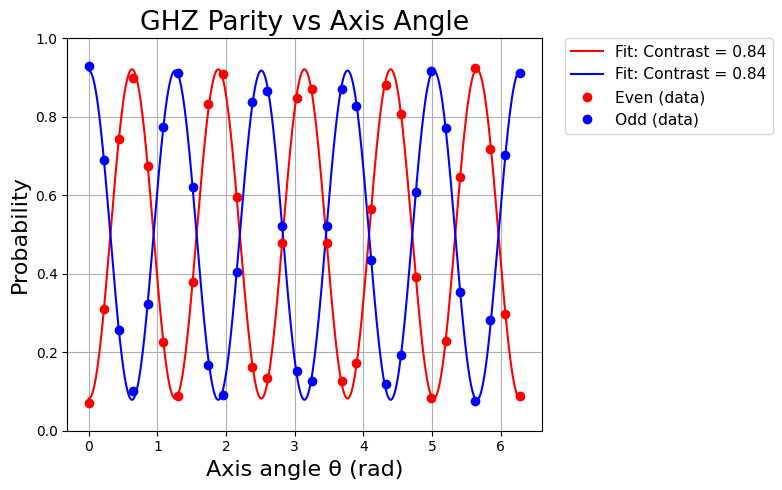

Extracted contrast: 0.839


In [182]:
num_qubits = 5

phi_vals, p_even_vals, p_odd_vals = run_parity_oscillations(num_qubits=num_qubits, num_shots=1024, num_points=num_qubits*6)

contrast = plot_parity_vs_theta_with_fit(phi_vals, p_even_vals, p_odd_vals, n_qubits=num_qubits, fs=16)
print(f"Extracted contrast: {contrast:.3f}")


## GHZ state of 10 qubits? Will take a minute to simulate...

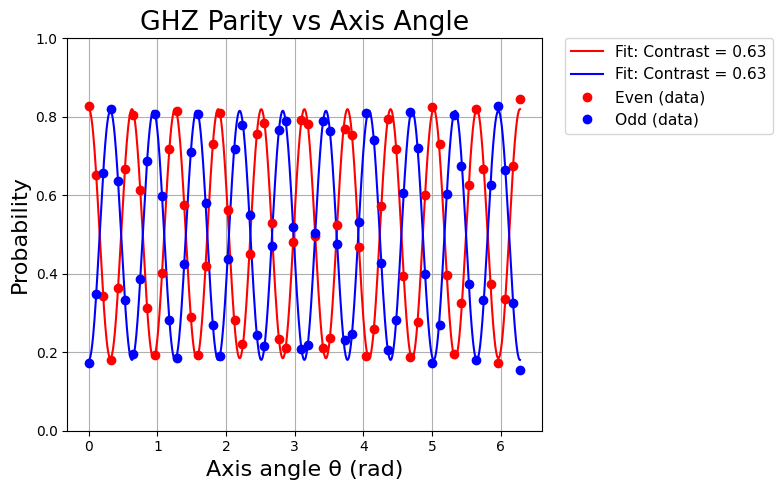

Extracted contrast: 0.635


In [183]:
num_qubits = 10

phi_vals, p_even_vals, p_odd_vals = run_parity_oscillations(num_qubits=num_qubits, num_shots=1024, num_points=num_qubits*6)

contrast = plot_parity_vs_theta_with_fit(phi_vals, p_even_vals, p_odd_vals, n_qubits=num_qubits, fs=16)
print(f"Extracted contrast: {contrast:.3f}")


## Parity oscillations of 15 qubit GHZ state? 

Would take a long time to simulate all of the angles of rotation...

Let's only scan over two fringes of the Parity oscillation instead to save time.

In [44]:
def run_parity_oscillations(num_qubits=3, num_shots=1024, num_points=30, phi_max=2*np.pi):
    """
    Sweep over phi values from 0 to phi_max and measure parity using FakeBrisbane.

    Args:
        num_qubits (int): Number of qubits in the GHZ state.
        num_shots (int): Number of measurement shots per circuit.
        num_points (int): Number of phi values to sweep.
        phi_max (float): Final value of phi in the sweep (default: 2π).

    Returns:
        tuple: (phi_vals, p_even_vals, p_odd_vals)
    """
    backend = FakeBrisbane()
    phi_vals = np.linspace(0, phi_max, num_points)
    p_even_vals = []
    p_odd_vals = []

    for phi in phi_vals:
        qc = create_ghz_circuit(num_qubits, phi)
        tqc = transpile(qc, backend)
        job = backend.run(tqc, shots=num_shots)
        result = job.result()
        counts = result.get_counts()
        p_even, p_odd = parity_probabilities(counts)
        p_even_vals.append(p_even)
        p_odd_vals.append(p_odd)

    return phi_vals, p_even_vals, p_odd_vals


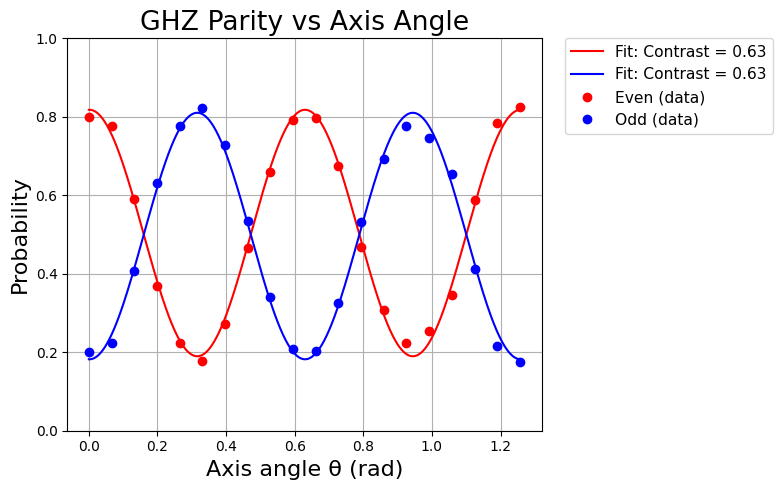

Extracted contrast: 0.628


In [195]:
num_qubits = 10

phi_vals, p_even_vals, p_odd_vals = run_parity_oscillations(num_qubits=num_qubits, num_shots=1024, num_points=20, phi_max=2*np.pi/(num_qubits/2))

contrast = plot_parity_vs_theta_with_fit(phi_vals, p_even_vals, p_odd_vals, n_qubits=num_qubits, fs=16)
print(f"Extracted contrast: {contrast:.3f}")


# 15 qubit GHZ state parity oscillations!

simulated in only a few minutes!

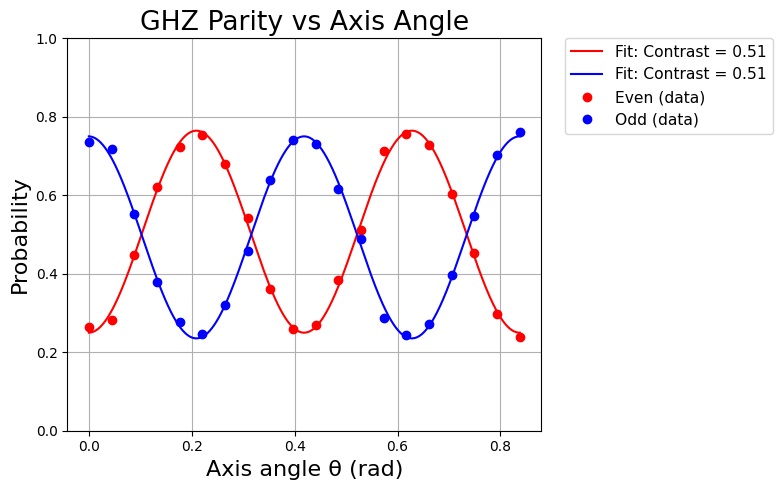

Extracted contrast: 0.515


In [196]:
num_qubits = 15

phi_vals, p_even_vals, p_odd_vals = run_parity_oscillations(num_qubits=num_qubits, num_shots=100, num_points=10, phi_max=2*np.pi/(num_qubits/2))

contrast = plot_parity_vs_theta_with_fit(phi_vals, p_even_vals, p_odd_vals, n_qubits=num_qubits, fs=16)
print(f"Extracted contrast: {contrast:.3f}")

This will take almost a few minutes to run:

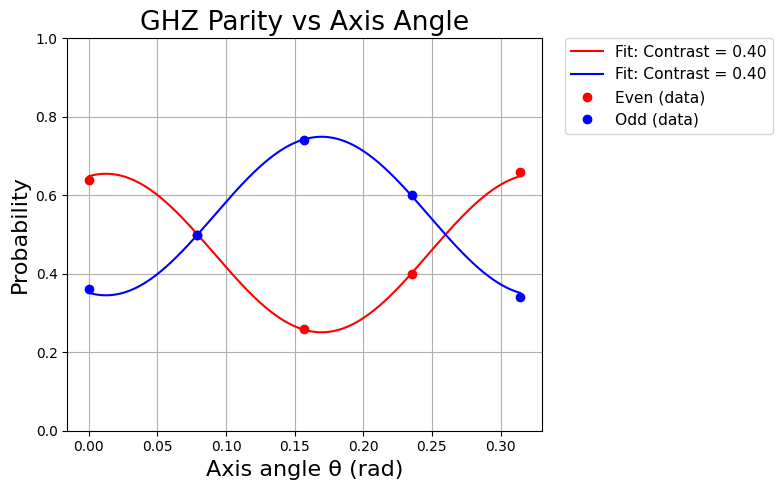

Extracted contrast: 0.404


In [ ]:
num_qubits = 20

phi_vals, p_even_vals, p_odd_vals = run_parity_oscillations(num_qubits=num_qubits, num_shots=100, num_points=7, phi_max=2*np.pi/(num_qubits))

contrast = plot_parity_vs_theta_with_fit(phi_vals, p_even_vals, p_odd_vals, n_qubits=num_qubits, fs=16)
print(f"Extracted contrast: {contrast:.3f}")

# GHZ parity contrast decay vs. number of qubits

Compiling these contrasts together we can now extract the decay of the GHZ state fidelity vs. number of qubits

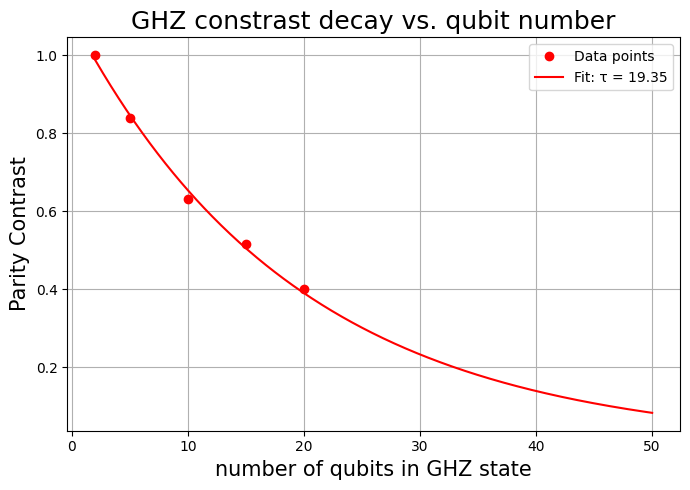

In [47]:
# Parity Constrast Data
x_vals = np.array([2, 5, 10, 15, 20])
y_vals = np.array([1.0, 0.839, 0.630, 0.515, 0.4])

# Exponential decay model
def decay_model(x, A, tau):
    return A * np.exp(-x / tau)

# Initial guess: A, tau, C
p0 = [1.0, 5.0]

# Fit the curve
popt, _ = curve_fit(decay_model, x_vals, y_vals, p0=p0)
A_fit, tau_fit = popt

# Smooth curve for plotting
x_smooth = np.linspace(2, 50, 500)
y_smooth = decay_model(x_smooth, *popt)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(x_vals, y_vals, 'or', label='Data points')
plt.plot(x_smooth, y_smooth, '-r',  label=f'Fit: τ = {tau_fit:.2f}')
plt.xlabel('number of qubits in GHZ state', fontsize =fs)
plt.ylabel('Parity Contrast', fontsize =fs)
plt.title('GHZ constrast decay vs. qubit number', fontsize =fs*1.2)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


https://qiskit-community.github.io/qiskit-dynamics/tutorials/qiskit_pulse.html

## Further reading:

### Application-Oriented Performance Benchmarks for Quantum Computing - https://arxiv.org/abs/2110.03137

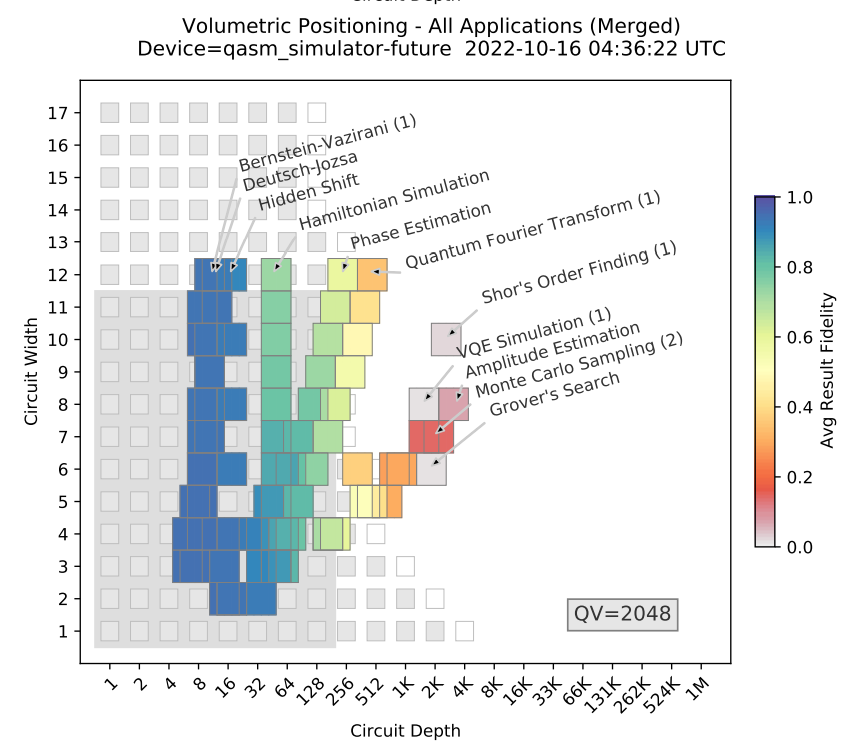

# Exercises

  1. What is the max T1 on ibm_brisbane? Verify it yourself.

  1. What is the maximum T2 on ibm_brisbane? Verify it.

  1. What is the expected largest GHZ state that can be made on ibm_brisbane? How can you determine this?

  1. Create a quantum volume circuit. What is the largest quantum volume you can simulate on ibm_brisbane?
  




In [ ]:
'''
Exercise 1
'''


In [ ]:
'''
Exercise 2
'''
